In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd
import numpy as np

/var/folders/tc/p_2dw00d5zg0svx3_qj__8tc0000gn/T/ipykernel_44816/3174091764.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Replace 0's with NaN
df['Glucose'] = df['Glucose'].replace(0, np.nan) # 1 observation med 0
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan) # 0 m 0
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan) # 0 m 0
df['Insulin'] = df['Insulin'].replace(0, np.nan) #236 observationer med 0
df['BMI'] = df['BMI'].replace(0, np.nan) # 1 med 0
df['Age'] = df['Age'].replace(0, np.nan) # 0 m 0
# Remove NaN rows in data
df_no_nan = df.dropna()
df_no_nan.to_csv('diabetes_removed_nan.csv', index=False)

new_df = pd.read_csv("diabetes_removed_nan.csv")

display(new_df.head())
len(new_df) #originalt: 768, efter alle: 392

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
1,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
2,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
3,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
4,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1


392

In [4]:
# Standardize data

features = [col for col in df.columns if col not in ['Outcome', 'DiabetesPedigreeFunction']]
x = new_df.loc[:, features].values
x = StandardScaler().fit_transform(x)
len(x.T)

7

Pregnancies
min 0 
max 17 
mean 3.3010204081632653 
median 2.0 
var 10.286937734277386
Low outliers: 0 High outliers: 22 Tot: 22 Percent: 0.056


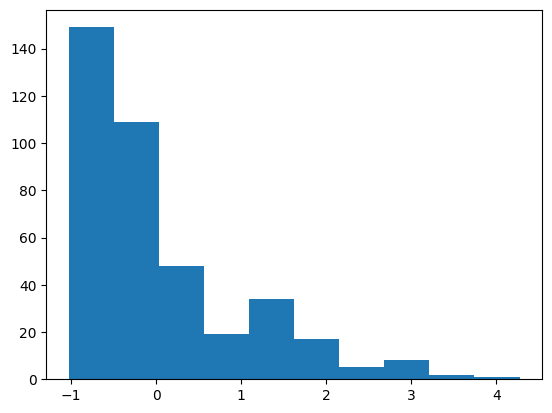

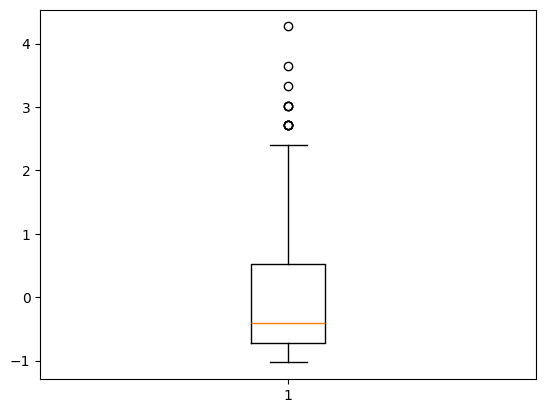

Glucose
min 56.0 
max 198.0 
mean 122.62755102040816 
median 119.0 
var 949.9582205331112
Low outliers: 0 High outliers: 11 Tot: 11 Percent: 0.028


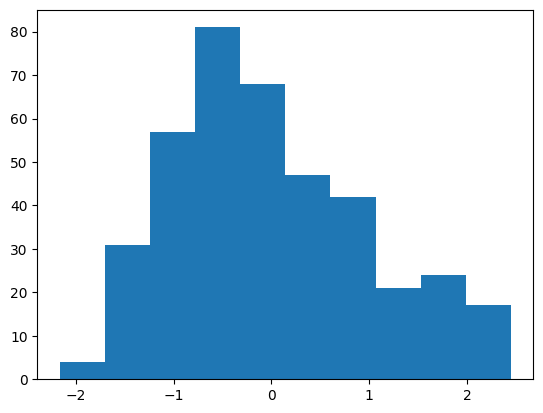

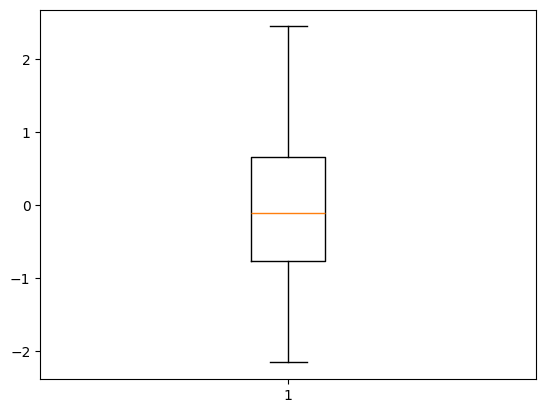

BloodPressure
min 24.0 
max 110.0 
mean 70.66326530612245 
median 70.0 
var 155.7539566847147
Low outliers: 8 High outliers: 8 Tot: 16 Percent: 0.041


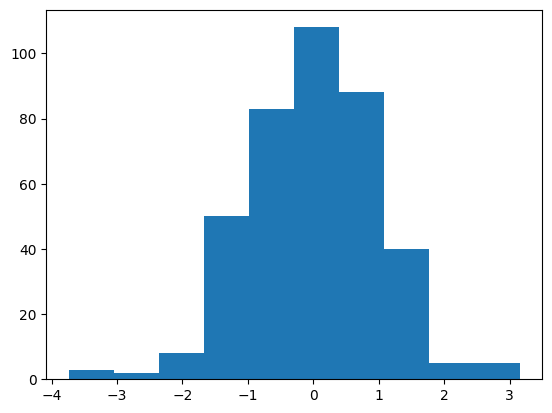

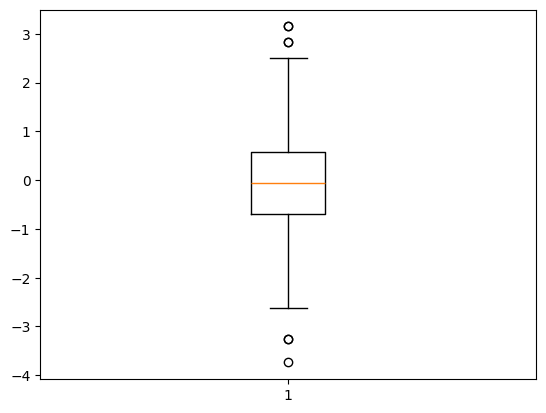

SkinThickness
min 7.0 
max 63.0 
mean 29.145408163265305 
median 29.0 
var 110.3130401395252
Low outliers: 0 High outliers: 3 Tot: 3 Percent: 0.008


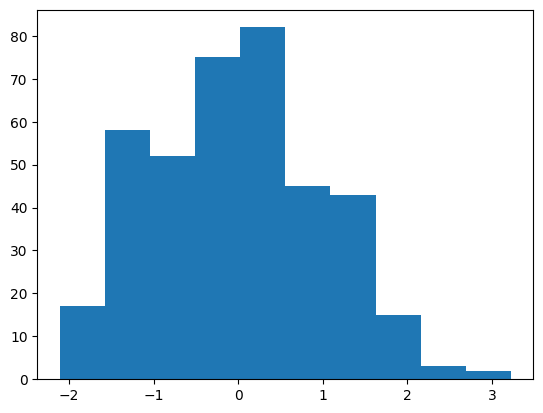

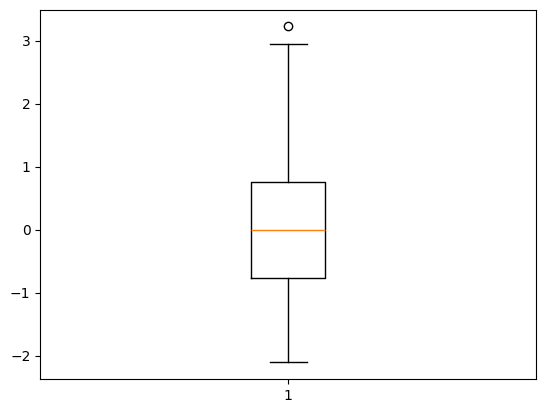

Insulin
min 14.0 
max 846.0 
mean 156.05612244897958 
median 125.5 
var 14087.318278842149
Low outliers: 0 High outliers: 37 Tot: 37 Percent: 0.094


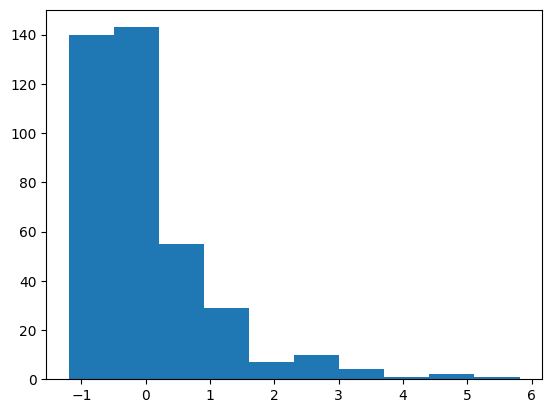

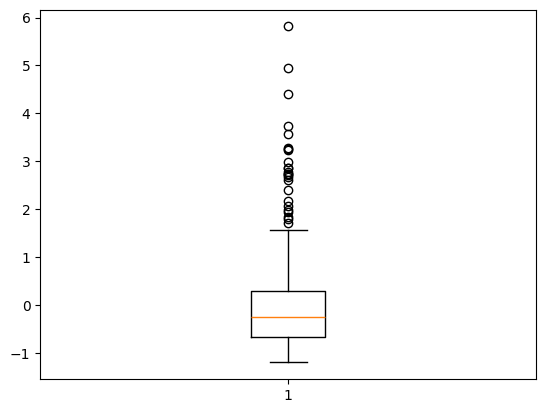

BMI
min 18.2 
max 67.1 
mean 33.08622448979592 
median 33.2 
var 49.26200411286964
Low outliers: 7 High outliers: 15 Tot: 22 Percent: 0.056


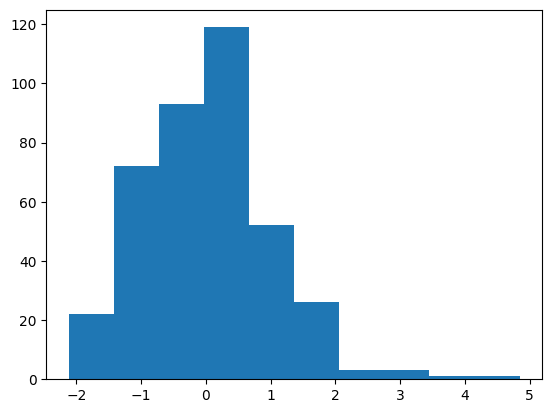

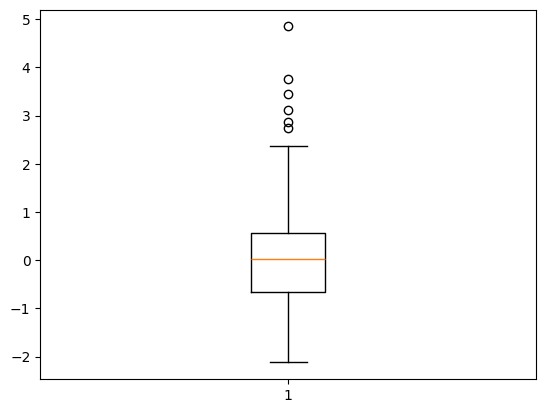

Age
min 21 
max 81 
mean 30.864795918367346 
median 27.0 
var 103.79039332569765
Low outliers: 0 High outliers: 32 Tot: 32 Percent: 0.082


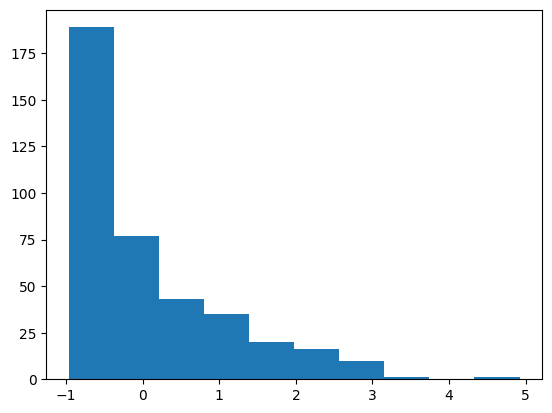

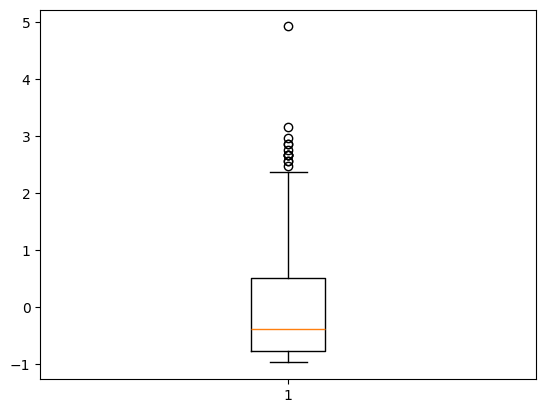

In [5]:
from scipy.stats import iqr
for i, att in enumerate(x.T):
    print(features[i])
    print('min', min(new_df[features[i]]), '\nmax', max(new_df[features[i]]), '\nmean', np.mean(new_df[features[i]])    
          , '\nmedian',  np.median(new_df[features[i]]), '\nvar', np.var(new_df[features[i]]))
    iqr_data = iqr(att)
    q1, q3 = np.quantile(att,0.25), np.quantile(att,0.75) 
    thresh_low, thresh_high = q1 - iqr_data, q3 + iqr_data
    out_low, out_high = 0,0
    for obs in att:
        if obs < thresh_low: out_low +=1
        if obs > thresh_high: out_high += 1
    print('Low outliers:', out_low, 'High outliers:', out_high, 'Tot:', out_high+out_low, 
          'Percent:', np.round((out_low+out_high)/len(att),3))
    plt.hist(att)
    plt.show()
    plt.boxplot(att)
    plt.show()

In [6]:
# PCA

pca = PCA()
principalComponents = pca.fit_transform(x)

In [7]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7'])

In [8]:
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_[:3])

[0.35931313 0.21922033 0.16852208 0.10846325 0.05740043 0.04444452
 0.04263626]


0.7470555387374158

/var/folders/tc/p_2dw00d5zg0svx3_qj__8tc0000gn/T/ipykernel_44816/633147097.py:5: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],


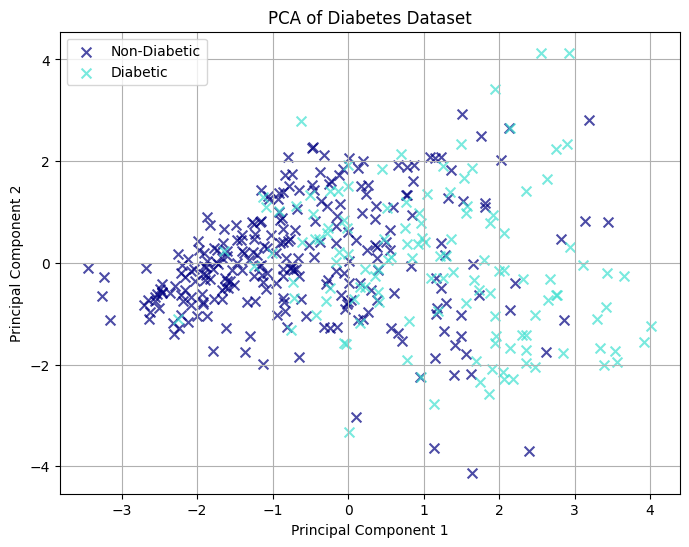

[-1.91422693  0.20052065 -0.11529684 -0.2090557   0.30851624 -0.19647147
 -0.08639281]
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']


In [9]:
plt.figure(figsize=(8, 6))

for outcome, color in zip([0, 1], ["#000080", "#40E0D0"]):
    indicesToKeep = new_df['Outcome'] == outcome
    plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
                principalDf.loc[indicesToKeep, 'principal component 2'],
                c=color, edgecolor='k', alpha=0.7, s=50, marker='x',
                label=('Non-Diabetic' if outcome == 0 else 'Diabetic'))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Diabetes Dataset')
plt.grid(True)
plt.legend()
plt.show()
print(principalComponents[0])
print(features)

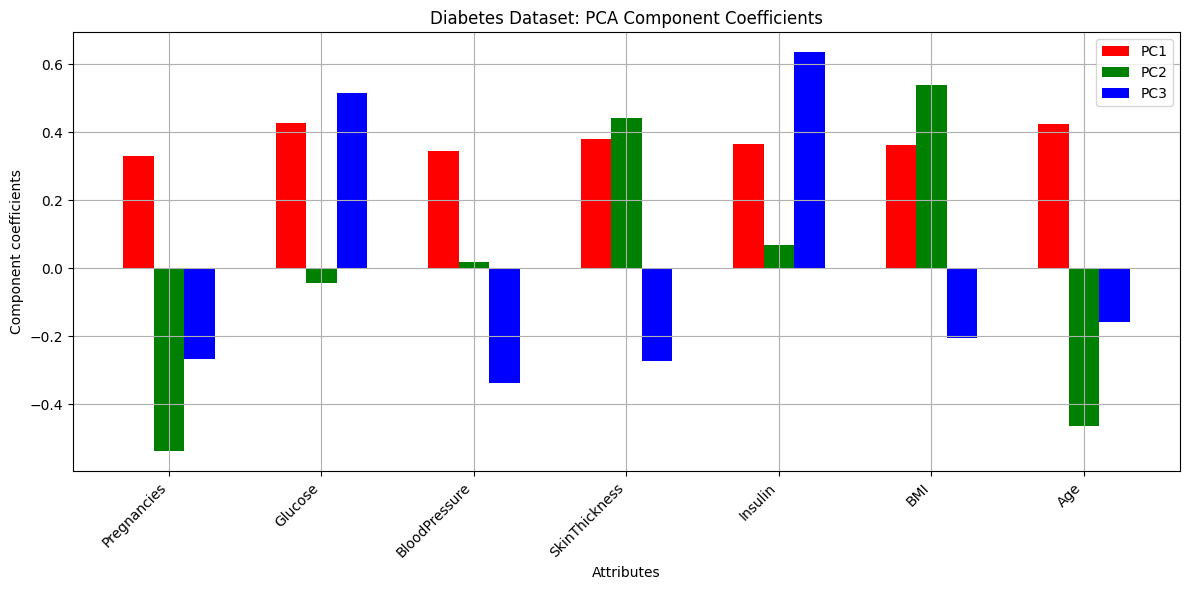

In [10]:
Y = x - np.ones((x.shape[0], 1)) * x.mean(0)
U, S, Vh = svd(Y, full_matrices=False)
V = Vh.T

new_new_df = new_df.drop(['Outcome', 'DiabetesPedigreeFunction'], axis=1)
attributeNames = list(new_new_df.columns)

pcs = [0, 1, 2]
legendStrs = ["PC" + str(e + 1) for e in pcs]
bw = 0.2
r = np.arange(1, len(attributeNames) + 1)
colors = ["r", "g", "b"]  

plt.figure(figsize=(12, 6))
for i in pcs:
    plt.bar(r + i * bw, V[:, i], width=bw, color=colors[i])
plt.xticks(r + bw, attributeNames, rotation=45, ha="right")
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.legend(legendStrs)
plt.grid()
plt.title("Diabetes Dataset: PCA Component Coefficients")
plt.tight_layout()  
plt.show()


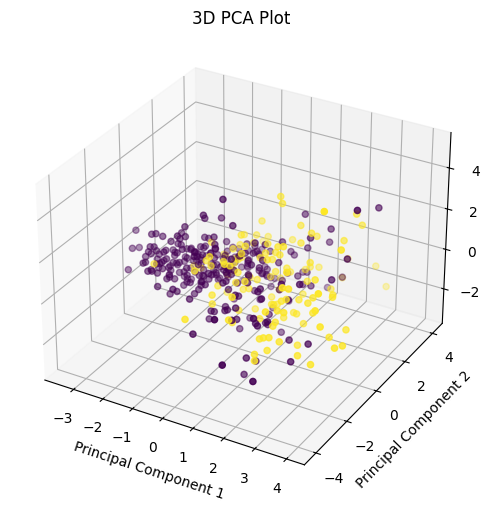

In [11]:
# Plotting 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extracting the values for each component
x_values = principalDf['principal component 1']
y_values = principalDf['principal component 2']
z_values = principalDf['principal component 3']
colors = new_df['Outcome']

# Plotting
ax.scatter(x_values, y_values, z_values, c = colors, cmap='viridis', marker='o')

# Adding labels for each axis
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Title
ax.set_title('3D PCA Plot')

# Show plot
plt.show()

In [12]:
import plotly.graph_objects as go
import pandas as pd

# Assuming 'principalDf' is your DataFrame and it includes 'principal component 1', 'principal component 2', 'principal component 3', and 'Outcome'

# Extracting the values for each component
x_values = principalDf['principal component 1']
y_values = principalDf['principal component 2']
z_values = principalDf['principal component 3']
colors = new_df['Outcome']  # Assuming this is a column in your DataFrame for diabetes outcome

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x_values,
    y=y_values,
    z=z_values,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# Adding labels for each axis
fig.update_layout(
    title='3D PCA Plot',
    scene = dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    margin=dict(r=0, b=0, l=0, t=0)  # Tighten the margin to use space effectively
)

# Show plot
fig.show()
